In [543]:
%load_ext autoreload
%autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [544]:
import sys
sys.path.insert(1, '/home/gusinskaia/scintools/scintools')
import ththmod as THTH

In [545]:
import baseband
from baseband import guppi
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pulsarbat as pb
from glob import glob
import os, sys, math, time

from astropy.time import Time
from astropy import units as u
from astropy.visualization import quantity_support

from astropy import constants as const

import numpy as np
import astropy
from matplotlib.colors import LogNorm

import matplotlib as mpl
from scipy.sparse.linalg import eigsh
from scipy.optimize import curve_fit
import scipy.linalg

import load_data as ld
import ds_psr as dsa
import fit_thth as fth
import models_thth as mth


plt.rcParams['figure.dpi'] = 50
print (baseband.__version__)
print (pb.__version__)
print (astropy.__version__)


import concurrent.futures
import datetime


4.0.1
0.0.3
3.0


In [546]:
trdir='/mnt/scratch-lustre/gusinskaia/triple_system/'
odir=trdir+'dss_mean/'
fitdir=trdir+'for_fit/'
npydir=trdir+'npys_vels/'
imdir=trdir+'fitted_figures/'
vlbidir=trdir+'dss_realvlba/'
longdir=trdir+'dss_long/'
onetotwo_dir=trdir+'dss_1to2/'
twotofour_dir=trdir+'dss_2to4/'
armdir=trdir+'one_armed_arc/'
nsdir=trdir+'dss_wsrt_wnoise/'

spec_pieces=np.array([[1301,1317],[1321,1337],[1341,1357],[1361,1377],[1381,1397],
                      [1401,1417],[1421,1437],[1441,1457]])

In [572]:
list_2to4=sorted(glob(nsdir+'*.npz'))
list_2to4

['/mnt/scratch-lustre/gusinskaia/triple_system/dss_wsrt_wnoise/5607130_WSRT_1400_wnoise.npz',
 '/mnt/scratch-lustre/gusinskaia/triple_system/dss_wsrt_wnoise/5607130_WSRT_1400_wnoise_data.npz',
 '/mnt/scratch-lustre/gusinskaia/triple_system/dss_wsrt_wnoise/5607431_WSRT_1400_wnoise.npz',
 '/mnt/scratch-lustre/gusinskaia/triple_system/dss_wsrt_wnoise/5608723_WSRT_1400_wnoise.npz',
 '/mnt/scratch-lustre/gusinskaia/triple_system/dss_wsrt_wnoise/5608733_WSRT_1400_wnoise.npz',
 '/mnt/scratch-lustre/gusinskaia/triple_system/dss_wsrt_wnoise/5609121_WSRT_1400_wnoise.npz',
 '/mnt/scratch-lustre/gusinskaia/triple_system/dss_wsrt_wnoise/5609135_WSRT_1400_wnoise.npz',
 '/mnt/scratch-lustre/gusinskaia/triple_system/dss_wsrt_wnoise/5609846_WSRT_1400_wnoise.npz',
 '/mnt/scratch-lustre/gusinskaia/triple_system/dss_wsrt_wnoise/5609859_WSRT_1400_wnoise.npz',
 '/mnt/scratch-lustre/gusinskaia/triple_system/dss_wsrt_wnoise/5610532_WSRT_1400_wnoise.npz',
 '/mnt/scratch-lustre/gusinskaia/triple_system/dss_wsrt

In [578]:
rd=np.load(list_2to4[1])

data=rd['data']
amp=rd['amp']
templ=rd['templ']
bg=rd['bg']
w=rd['weights']
dprof=(data*w[...,None]).mean(axis=(0,1))

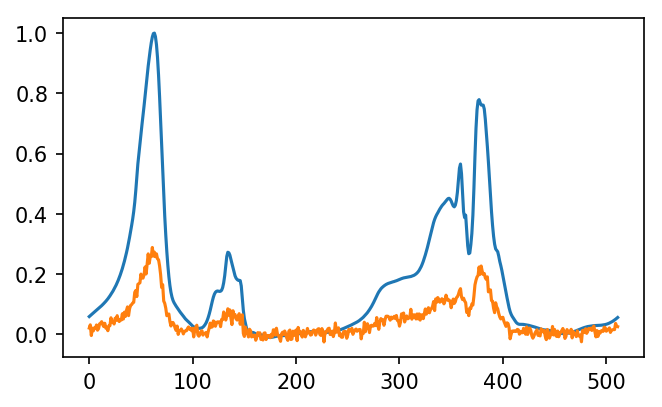

In [577]:
fig=plt.figure(figsize=(5,3), dpi=150)
plt.plot(templ)
plt.plot(dfrop)


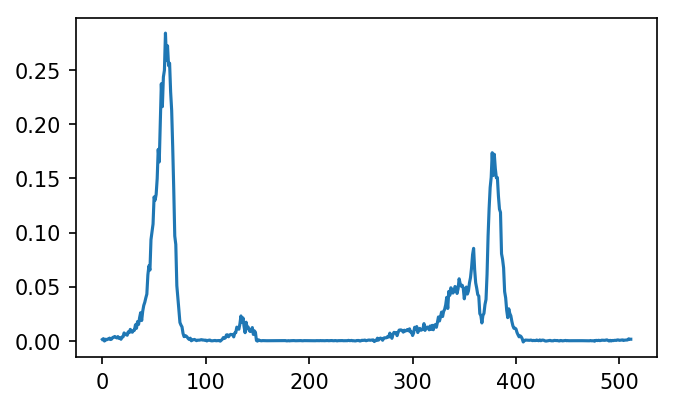

In [622]:
fig=plt.figure(figsize=(5,3), dpi=150)
plt.plot(templ*dprof)

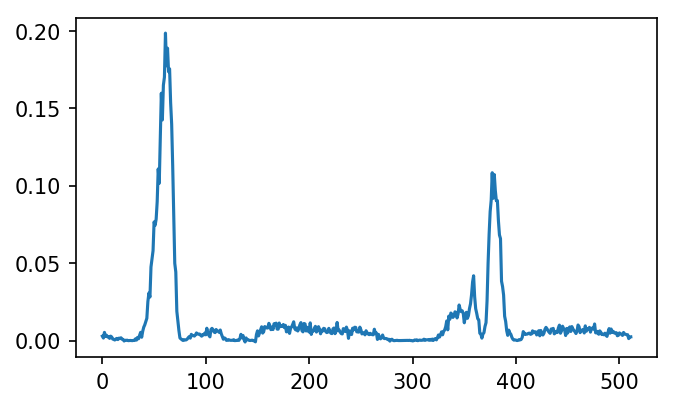

In [626]:
fig=plt.figure(figsize=(5,3), dpi=150)
plt.plot(tz*pz)

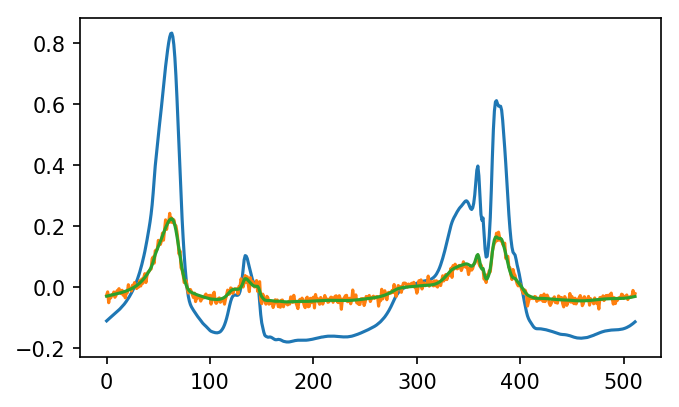

In [580]:
tz=templ-templ.mean()
d= data-data.mean(axis=-1, keepdims=True)
pz=dprof-np.mean(dprof)

tz_sc=tz*amp+bg
fig=plt.figure(figsize=(5,3), dpi=150)
plt.plot(tz)
plt.plot(pz)
plt.plot(tz_sc)

In [628]:
variance=np.var(d-tz_sc, axis=-1, keepdims=True)

j = np.sum(d*tz_sc, axis=-1)
all_data=j[w!=0]
j[w==0] = np.mean(all_data)


ns = np.sqrt(np.sum(variance*tz_sc**2, axis=-1))
all_noise=ns[w!=0]
ns[w==0] = np.mean(all_noise)

[ 2.  2.  2.  2.]
512
[1422  512]
(88, 512)
1.18581412336 1.072390329


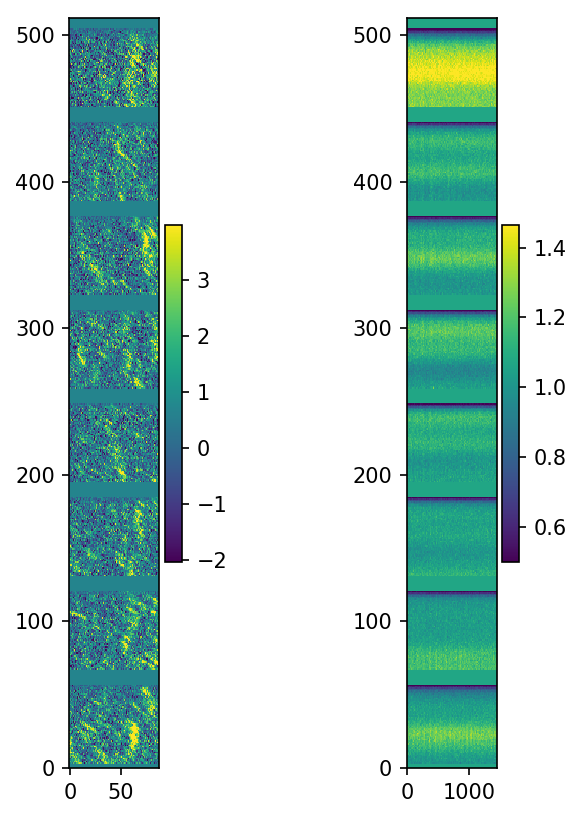

In [632]:
fc=16
j_shr=ld.shrink_2(j, factor=[fc,1])
ns_shr=ns/np.sqrt(fc)

fig=plt.figure(figsize=(3,5), dpi=150)
fig.add_axes([0.0,0.0,0.25,1])
plt.gca()
vmin, vmax=np.percentile(j_shr, [1,99])
plt.imshow(j_shr.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
fig.add_axes([0.75,0.0,0.25,1])
plt.gca()
vmin, vmax=np.percentile(ns_shr, [1,99])
plt.imshow(ns_shr.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()

print (np.std(j_shr), np.mean(ns_shr))

In [604]:
list_2to4=sorted(glob(armdir+'*.npz'))
sp=dsa.load_triple_spectrum(list_2to4[0], factor=[16,1],wnoise=False)
sp

(1439, 512)
[ 2.  2.  2.  2.]
512
[1422  512]
(88, 512)
[ 2.  2.  2.  2.]
512
[1422  512]
(88, 512)


<Dynamic spectrum: Dur: 4.00 hr, Freq: 1300.00 - 1460 MHz, MJD: 56071.30, PSR: PSRJ0337+1715, Tel: WSRT, no noise>

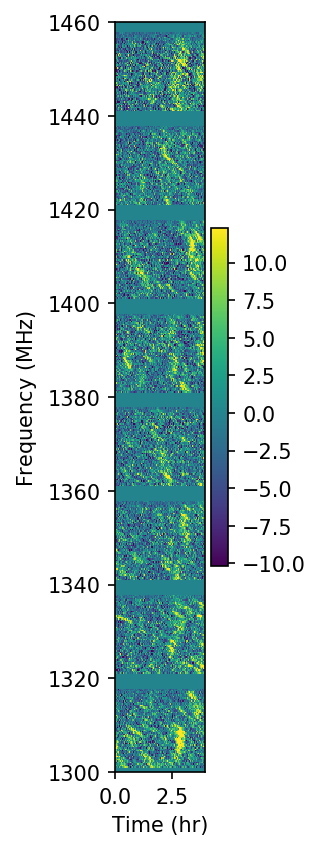

In [605]:
fig=plt.figure(figsize=(3,5), dpi=150)
fig.add_axes([0.0,0.0,0.25,1])
plt.gca()
sp.plot_ds(new_fig=False)
plt.colorbar()

In [559]:
sp=dsa.load_triple_spectrum(list_2to4[0], factor=[16,1], wnoise=True, mean0=False)
print (np.shape(sp.I), np.shape(sp.nI))
sp

(1439, 512)
[ 2.  2.  2.  2.]
512
[1422  512]
(88, 512)
[ 2.  2.  2.  2.]
512
[1422  512]
(88, 512)
(88, 512) (88, 512)


<Dynamic spectrum: Dur: 4.00 hr, Freq: 1300.00 - 1460 MHz, MJD: 56071.30, PSR: PSRJ0337+1715, Tel: WSRT, w noise>

In [560]:
print (np.std(sp.I), np.mean(sp.nI))

2.55722152968 1.35197146189


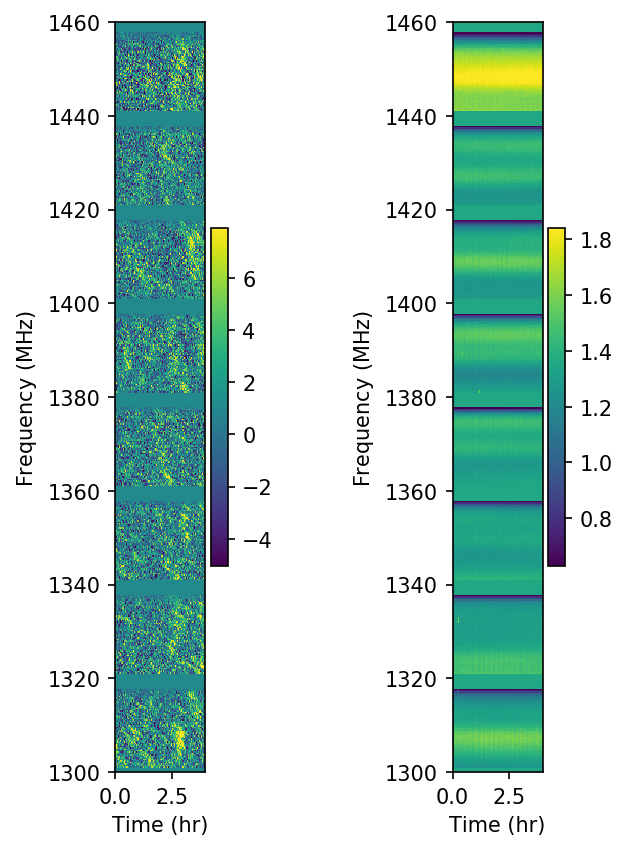

In [561]:
fig=plt.figure(figsize=(3,5), dpi=150)
fig.add_axes([0.0,0.0,0.25,1])
plt.gca()
sp.plot_ds(new_fig=False)
plt.colorbar()
fig.add_axes([0.75,0.0,0.25,1])
plt.gca()
sp.plot_nds(new_fig=False)
plt.colorbar()

In [562]:
this_spec=dsa.load_triple_spectrum(list_2to4[0], factor=[1,1], wnoise=True)
i=0
spec_sel=this_spec.select(time_sel=[this_spec.stend[0]*u.d,this_spec.stend[1]*u.d],
                                            freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])

spec_sel.ss=spec_sel.make_ss(pad_it=True, npad=3)

(1079, 512)
1079
512
[1079  512]
(1079, 512)
1079
512
[1079  512]
(1079, 512)


In [563]:
np.mean(spec_sel.f)

<Quantity 1308.9236790606653 MHz>

In [564]:
np.std(spec_sel.I)/np.mean(spec_sel.nI)

1.9102118613672359

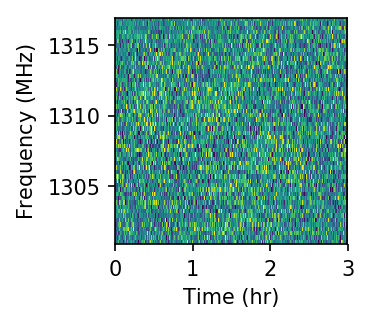

In [492]:
spec_sel.plot_ds(figsize=(2,2))

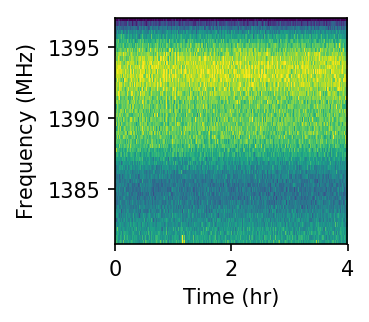

In [389]:
spec_sel.plot_nds(figsize=(2,2))

In [183]:
#try thth_redplot
fitdic, fit_freq, fit_time, res_dic=fth.daniel_pars_fit(spec_sel, curv_par='eta', etas_pars=[0.25,5.5,0.25])

fit: <Dynamic spectrum: Dur: 3.00 hr, Freq: 1381.10 - 1397 MHz, MJD: 56087.23, PSR: PSRJ0337+1715, Tel: WSRT, no noise>
shape of ss: (208, 532)
shape of thth_red and edges: (511, 511) (512,)
shape of thth2_red: (511, 511)
shape of V: (511,)
shape of recov: (208, 532)
shape of model: (208, 532)
shape of ss: (208, 532)
shape of thth_red and edges: (511, 511) (512,)
shape of thth2_red: (511, 511)
shape of V: (511,)
shape of recov: (208, 532)
shape of model: (208, 532)
shape of ss: (208, 532)
shape of thth_red and edges: (511, 511) (512,)
shape of thth2_red: (511, 511)
shape of V: (511,)
shape of recov: (208, 532)
shape of model: (208, 532)
shape of ss: (208, 532)
shape of thth_red and edges: (511, 511) (512,)
shape of thth2_red: (511, 511)
shape of V: (511,)
shape of recov: (208, 532)
shape of model: (208, 532)
shape of ss: (208, 532)
shape of thth_red and edges: (511, 511) (512,)
shape of thth2_red: (511, 511)
shape of V: (511,)
shape of recov: (208, 532)
shape of model: (208, 532)
shape

shape of thth_red and edges: (287, 287) (288,)
shape of thth2_red: (287, 287)
shape of V: (287,)
shape of recov: (208, 532)
shape of model: (208, 532)
shape of ss: (208, 532)
shape of thth_red and edges: (283, 283) (284,)
shape of thth2_red: (283, 283)
shape of V: (283,)
shape of recov: (208, 532)
shape of model: (208, 532)
shape of ss: (208, 532)
shape of thth_red and edges: (281, 281) (282,)
shape of thth2_red: (281, 281)
shape of V: (281,)
shape of recov: (208, 532)
shape of model: (208, 532)
shape of ss: (208, 532)
shape of thth_red and edges: (279, 279) (280,)
shape of thth2_red: (279, 279)
shape of V: (279,)
shape of recov: (208, 532)
shape of model: (208, 532)
shape of ss: (208, 532)
shape of thth_red and edges: (275, 275) (276,)
shape of thth2_red: (275, 275)
shape of V: (275,)
shape of recov: (208, 532)
shape of model: (208, 532)
shape of ss: (208, 532)
shape of thth_red and edges: (273, 273) (274,)
shape of thth2_red: (273, 273)
shape of V: (273,)
shape of recov: (208, 532)
s

shape of recov: (208, 532)
shape of model: (208, 532)
shape of ss: (208, 532)
shape of thth_red and edges: (205, 205) (206,)
shape of thth2_red: (205, 205)
shape of V: (205,)
shape of recov: (208, 532)
shape of model: (208, 532)
shape of ss: (208, 532)
shape of thth_red and edges: (205, 205) (206,)
shape of thth2_red: (205, 205)
shape of V: (205,)
shape of recov: (208, 532)
shape of model: (208, 532)
shape of ss: (208, 532)
shape of thth_red and edges: (203, 203) (204,)
shape of thth2_red: (203, 203)
shape of V: (203,)
shape of recov: (208, 532)
shape of model: (208, 532)
shape of ss: (208, 532)
shape of thth_red and edges: (203, 203) (204,)
shape of thth2_red: (203, 203)
shape of V: (203,)
shape of recov: (208, 532)
shape of model: (208, 532)
shape of ss: (208, 532)
shape of thth_red and edges: (201, 201) (202,)
shape of thth2_red: (201, 201)
shape of V: (201,)
shape of recov: (208, 532)
shape of model: (208, 532)
shape of ss: (208, 532)
shape of thth_red and edges: (201, 201) (202,)


33792

In [51]:
fitdic['eta']

<Quantity 2.393946941175868 us / mHz2>

eta: 2.393946941175868 us / mHz2 mueff: 5.771856991829163 mas / yr dveff: 0.986428428453687 km / (pc(1/2) s)
eta_err: 0.054807589587348673 us / mHz2 mueff: 0.06607113209653256 mas / yr dveff_err: 0.011291763308134925 km / (pc(1/2) s)


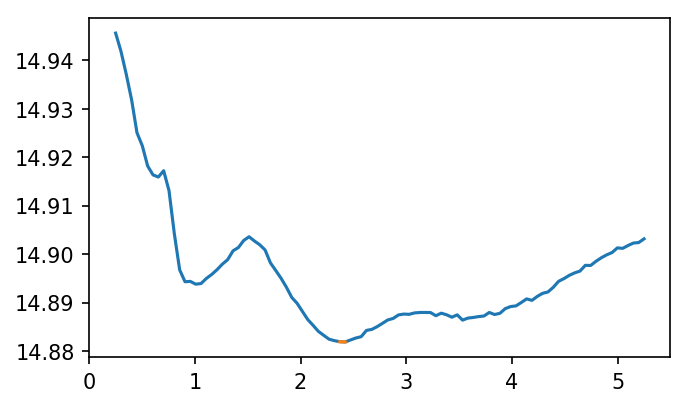

In [167]:
plt.figure(figsize=(5,3), dpi=150)
plt.plot(res_dic['par_array'],res_dic['chi2'])

fitted_range=((res_dic['par_array']>(res_dic['par_fit']-res_dic['par_sig'])) &
                                 (res_dic['par_array']<(res_dic['par_fit']+res_dic['par_sig'])))

plt.plot(res_dic['par_array'][fitted_range],res_dic['chi2'][fitted_range])

print ('eta:', fitdic['eta'], 'mueff:', fitdic['mueff'], 'dveff:',  fitdic['dveff'])
print ('eta_err:', fitdic['eta_err'], 'mueff:', fitdic['mueff_err'], 'dveff_err:',  fitdic['dveff_err'])

In [52]:
fitdic['dveff']

<Quantity 0.986428428453687 km / (pc(1/2) s)>

In [55]:
model_E, model_ds, model_ss, model_field, chi2 = mth.get_models(spec_sel, fitdic['eta'],
                                                                edge=1.4,ntau=512)

model_spec=mth.ModelSpec(eta=fitdic['eta'], mI=model_ds, mIs=model_ss, mE=model_E, mEs=model_field,
                         spec=spec_sel)

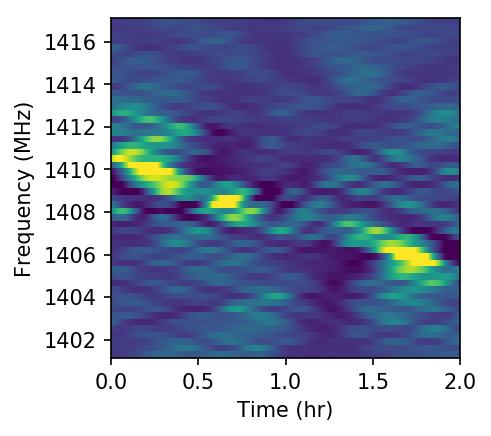

In [56]:
model_spec.plot_mds()

In [ ]:
def get_curv_fits_wsrt(name, figsize=(5,7.5), spec_pieces='Default', etas_pars=[0.25,7.5,0.25], method='chi2',
                      pc7=False, load_model=False, eta_ref=None, ref_freq=None, edge=1.4, save_models=False,
                      who='Daniel', d_eff=1300*u.pc):
    if spec_pieces=='Default':
        if pc7 is True:
            spec_pieces=np.array([[1312,1328],[1332,1348],[1352,1368],[1372,1388],[1392,1408],
                      [1412,1428],[1432,1448]])
        else:
            spec_pieces=np.array([[1301,1317],[1321,1337],[1341,1357],[1361,1377],[1381,1397],
                      [1401,1417],[1421,1437],[1441,1457]])
    else:
        spec_pieces=spec_pieces
    shr_spec=load_triple_spectrum(name, factor=[16,1])
    this_spec=load_triple_spectrum(name, factor=[1,1])

    my_specs=[]
    shr_specs=[]
    if (shr_spec.stend[1]-shr_spec.stend[0])>3.2/24.:
        break_mjd=(shr_spec.stend[1]+shr_spec.stend[0])/2
        st_spec=this_spec.select(time_sel=[this_spec.stend[0]*u.d,break_mjd*u.d])
        end_spec=this_spec.select(time_sel=[break_mjd*u.d,this_spec.stend[1]*u.d])
        my_specs.append(st_spec)
        my_specs.append(end_spec)

        st_spec_shr=shr_spec.select(time_sel=[shr_spec.stend[0]*u.d,break_mjd*u.d])
        end_spec_shr=shr_spec.select(time_sel=[break_mjd*u.d,shr_spec.stend[1]*u.d])
        shr_specs.append(st_spec_shr)
        shr_specs.append(end_spec_shr)
    else:
        my_specs.append(this_spec)
        shr_specs.append(shr_spec)

    etas, etas_err, etas_f, etas_t, dics_etas, all_models, delays=[],[],[],[],[],[],[]
    f = open("etas_results_fit_%.2f_%s.txt"%(this_spec.stend[0],who), "a")
    if load_model is False:
        h = open("delay_results_fit_%.2f_%s.txt"%(this_spec.stend[0],who), "a")
    else:
        h = open("delay_results_model_%.2f.txt"%this_spec.stend[0], "a")
    j=0
    for my_spec in my_specs:
        fig=plt.figure(figsize=figsize, dpi= 70, facecolor='w', edgecolor='k')
        fig.add_axes([0.0,0.0,0.25,1.0])
        plt.gca()
        shr_specs[j].plot_ds(new_fig=False)
        for i in range(0,spec_pieces.shape[0]):
            spec_sel=my_spec.select(time_sel=[my_spec.stend[0]*u.d,my_spec.stend[1]*u.d],
                                            freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])
            fig.add_axes([0.9,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            spec_sel.plot_ss(new_fig=False, cb=False, fd_lim=[-2.0,2.0], tau_lim=[0.0,1.3],vmin=1e7,vmax=1e9)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            spec_sel.get_noise()
            if load_model is False:

                if who=='Daniel':
                    eta, eta_err, eta_f, eta_t, dic_etas=get_daniel_eta_fit(spec_sel, etas_pars=etas_pars,
                                                                                edge=edge,ntau=512,method=method)
                if who=='Marten':
                    eta, eta_err, eta_f, eta_t, dic_etas=get_marten_mueff_fit(spec_sel, d_eff,
                                                        etas_pars=etas_pars, edge=edge,ntau=512)
                if np.isnan(eta):
                    if i==0:
                        print ('not correct eta, take highest value')
                        eta=etas_pars[1]*eta_err.unit
                    else:
                        print ('scales eta, because the fit did not converge')
                        eta=etas[i-1]*(etas_f[i-1]/eta_f)**2
                f.write('%.3f, %.3f, %.3f, %.3f \n'%(eta.value, eta_err.value, eta_f.value, eta_t))
                dics_etas.append(dic_etas)
            else:
                eta=eta_ref*(ref_freq/spec_sel.f.mean())**2
                eta_err=0.0*eta.unit
                eta_f=np.mean(spec_sel.f)
                eta_t=np.mean(spec_sel.mjd.mjd)

            etas.append(eta)
            etas_err.append(eta_err)
            etas_f.append(eta_f)
            etas_t.append(eta_t)

            print (eta, eta_err, eta_f, eta_t)

            model_E, model_ds, model_ss, model_field = get_models(spec_sel, eta, edge=edge,ntau=512)
            model_spec=ModelSpec(eta=eta, mI=model_ds, mIs=model_ss, mE=model_E, mEs=model_field,
                                     spec=spec_sel)
            extent=ext_find(model_spec.spec.ss.fd, model_spec.spec.ss.tau)
            tau_axis=np.linspace(extent[2],extent[3], np.shape(model_spec.mEs)[0])
            delay_es=model_spec.mEs.sum(1)
            tau_axis_pos=tau_axis[(tau_axis>0)]
            delay_es_pos=delay_es[(tau_axis>0)]
            my_delay=np.average(tau_axis_pos, weights=delay_es_pos)
            h.write('%.3f, %.3f, %.3f \n'%(my_delay, eta_f.value, eta_t))
            delays.append(my_delay)

            fig.add_axes([0.3,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_mds(new_fig=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([0.6,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_me(new_fig=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([1.2,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_mss(new_fig=False, cb=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([1.5,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_mes(new_fig=False, cb=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([1.8,0.006+0.125*i,0.25, 0.105])
            if save_models is True:
                all_models.append(model_spec)
            if load_model is False:
                frame1=plt.gca()
                plot_etas(dic_etas,new_fig=False)
                frame1.axes.get_xaxis().set_ticks([])
                frame1.axes.get_yaxis().set_ticks([])
                aux_name='fullfit'
            else:
                aux_name='fullmodel_%.1f'%eta.value
            print ('----------')
        plt.savefig('triple_%.2f_%s_%s_%s.png'%(my_spec.stend[0],my_spec.tel,aux_name,who),format='png',
                    bbox_inches='tight',dpi=70)
        plt.show()
        j=j+1
    f.close()
    h.close()
    return etas, etas_err, etas_f, etas_t, dics_etas, all_models, delays


In [ ]:
def get_daniel_dveff_fit_wsrt(myspec, etas_pars=[0.5,7.5,0.25], edge=1.4,ntau=512,
                            spec_pieces='Default', neta=100, ind_mean0=True):
    print ('Method chi2:', myspec)
    if spec_pieces=='Default':
        spec_pieces=np.array([[1301,1317],[1321,1337],[1341,1357],[1361,1377],[1381,1397],
                      [1401,1417],[1421,1437],[1441,1457]])
    
    
    etas_init=np.arange(etas_pars[0],etas_pars[1],etas_pars[2])
    ##Define range of curvatures to search
    eta_low=np.amin(etas_init)*u.us/(u.mHz**2)
    eta_high=np.amax(etas_init)*u.us/(u.mHz**2)

    dveff_low=eta_to_dveff(eta_high, myspec)
    dveff_high=eta_to_dveff(eta_low, myspec)

    dveffs2=np.linspace(dveff_high.value,dveff_low.value,neta)*dveff_low.unit
    chisq=np.zeros(dveffs2.shape[0])
    edges=np.linspace(-edge,edge,ntau)
    ref_freq=myspec.f.mean()
    
    specs=[]
    for i in range(0,spec_pieces.shape[0]):
        spec_sel=myspec.select(time_sel=[myspec.stend[0]*u.d,myspec.stend[1]*u.d],
                                        freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])
        if ind_mean0 is True:
            spec_sel.I=spec_sel.I-np.mean(spec_sel.I)
            spec_sel.ss=spec_sel.make_ss(pad_it=True, npad=3)
        specs.append(spec_sel)
    
    for i in range(dveffs2.shape[0]):
        dveff=dveffs2[i]
        this_chi2s=[]
        etas3=[]
        for spec_p in specs:
            eta=dveff_to_eta(dveffs2[i],spec_p)
            this_chi2=dsa.daniel_get_chi2_spec(spec_sel, eta, edge, ntau)
            this_chi2s.append(this_chi2)
            etas3.append(eta.value)
        chisq[i]=np.mean(this_chi2s)
        print (i, np.mean(etas3), dveff, chisq[i])
            
    dveff_min=dveffs2[chisq==chisq.min()][0]
    fit_results=chisq[np.abs(dveffs2-dveff_min)<.1*dveff_min]
    C=fit_results.min()            
    measure=chisq
    dveffs_fit=dveffs2[np.abs(dveffs2-dveff_min)<.1*dveff_min]
    x0=dveffs_fit[fit_results==C][0].value
    A=(fit_results[0]-C)/((dveffs_fit[0].value-x0)**2)
    
    try:
        popt,pcov=curve_fit(THTH.chi_par,dveffs_fit.value,fit_results,p0=np.array([A,x0,C]))
        dveff_fit=popt[1]*dveffs2.unit
        dveff_sig=np.sqrt((fit_results-THTH.chi_par(dveffs_fit.value,*popt)).std()/popt[0])*dveffs2.unit
    except RuntimeError:
        print('Fit curve didnt converge')
        vdeff_fit, dveff_sig, popt=float('nan') , 0.0*dveffs_fit.unit,  0.0
    except TypeError:
        print ('Improper input: N=3 must not exceed M=1; -- why?')
        vdeff_fit, dveff_sig, popt=float('nan') , 0.0*dveffs_fit.unit,  0.0
    
    dveffs_dic={'etas':dveffs2, 'etas_fit':dveffs_fit, 'measure':measure, 'etas_fit_res':popt,
              'eta_fit':dveff_fit, 'eta_sig':dveff_sig}
    return dveff_fit, dveff_sig, np.mean(myspec.f), np.mean(myspec.mjd.mjd), dveffs_dic


def get_curv_simfits_wsrt(name, figsize=(5,7.5), spec_pieces='Default', etas_pars=[0.5,7.5,0.25], method='chi2',
                      pc7=False, edge=1.4,who='Daniel', time_lim=2.5,
                       d_eff=1300*u.pc, mean0=True, ind_mean0=False):
    if spec_pieces=='Default':
        if pc7 is True:
            spec_pieces=np.array([[1312,1328],[1332,1348],[1352,1368],[1372,1388],[1392,1408],
                      [1412,1428],[1432,1448]])
        else:
            spec_pieces=np.array([[1301,1317],[1321,1337],[1341,1357],[1361,1377],[1381,1397],
                      [1401,1417],[1421,1437],[1441,1457]])
    else:
        spec_pieces=spec_pieces
    shr_spec=dsa.load_triple_spectrum(name, factor=[16,1], mean0=mean0)
    this_spec=dsa.load_triple_spectrum(name, factor=[1,1], mean0=mean0)
    
    my_specs=[]
    shr_specs=[]
    if (shr_spec.stend[1]-shr_spec.stend[0])>time_lim/24.:
        break_mjd=(shr_spec.stend[1]+shr_spec.stend[0])/2
        st_spec=this_spec.select(time_sel=[this_spec.stend[0]*u.d,break_mjd*u.d])
        end_spec=this_spec.select(time_sel=[break_mjd*u.d,this_spec.stend[1]*u.d])
        my_specs.append(st_spec)
        my_specs.append(end_spec)
        
        st_spec_shr=shr_spec.select(time_sel=[shr_spec.stend[0]*u.d,break_mjd*u.d])
        end_spec_shr=shr_spec.select(time_sel=[break_mjd*u.d,shr_spec.stend[1]*u.d])
        shr_specs.append(st_spec_shr)
        shr_specs.append(end_spec_shr)
    else:
        my_specs.append(this_spec)
        shr_specs.append(shr_spec)
    
    etas, etas_err, etas_f, etas_t, dics_etas=[],[],[],[],[]
    j=0
    for my_spec in my_specs:
        f = open("dveff_results_simfit_%s.txt"%who, "a")
        fig=plt.figure(figsize=figsize, dpi= 70, facecolor='w', edgecolor='k')
        fig.add_axes([0.0,0.0,0.25,1.0])
        plt.gca()
        shr_specs[j].plot_ds(new_fig=False)
        
        dveff_fit, dveff_sig, eta_freq, eta_mjd, etas_dic=get_daniel_dveff_fit_wsrt(my_spec, neta=100,
                                                                                etas_pars=etas_pars)
        f.write('%.3f, %.3f, %.3f, %.3f \n'%(dveff_fit.value, dveff_sig.value, eta_freq.value, eta_mjd))
        print ('%.3f, %.3f, %.3f, %.3f \n'%(dveff_fit.value, dveff_sig.value, eta_freq.value, eta_mjd))
        
        eta_ref=dveff_to_eta(dveff_fit, my_spec)
        ref_freq=my_spec.f.mean()
        for i in range(0,spec_pieces.shape[0]):
            spec_sel=my_spec.select(time_sel=[my_spec.stend[0]*u.d,my_spec.stend[1]*u.d],
                                            freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])
            
            fig.add_axes([0.9,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            spec_sel.plot_ss(new_fig=False, cb=False, fd_lim=[-2.0,2.0], tau_lim=[0.0,1.3],vmin=1e7,vmax=1e9)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])

            eta=eta_ref*(ref_freq/spec_sel.f.mean())**2
            eta_err=0.0*eta.unit
            eta_f=np.mean(spec_sel.f)
            eta_t=np.mean(spec_sel.mjd.mjd)
                
            etas.append(eta)
            etas_err.append(eta_err)
            etas_f.append(eta_f)
            etas_t.append(eta_t)
                    
            print (eta, eta_err, eta_f, eta_t)
            
            model_E, model_ds, model_ss, model_field, chi2 = dsa.get_models(spec_sel, eta, edge=edge,ntau=512)
            model_spec=dsa.ModelSpec(eta=eta, mI=model_ds, mIs=model_ss, mE=model_E, mEs=model_field,
                                     spec=spec_sel)
            
            fig.add_axes([0.3,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_mds(new_fig=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([0.6,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_me(new_fig=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([1.2,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_mss(new_fig=False, cb=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([1.5,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_mes(new_fig=False, cb=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            print ('----------')
        fig.add_axes([1.8,0.006+0.125*4,0.25, 0.105])
        frame1=plt.gca()
        dsa.plot_etas(etas_dic,new_fig=False)
        frame1.axes.get_xaxis().set_ticks([])
        frame1.axes.get_yaxis().set_ticks([])
        aux_name='dveff_%.1f'%dveff_fit.value
        plt.savefig('triple_%.2f_%s_%s_%s.png'%(my_spec.stend[0],my_spec.tel,aux_name,who),format='png',
                    bbox_inches='tight',dpi=70)
        plt.show()
        j=j+1
        f.close()
    return etas, etas_err, etas_f, etas_t, dics_etas